# Refactoring Dataset Importing

## Note-centric dataset

Rather than viewing the data as a collection of data sources (such as MAPS), each containing a collection of instruments, each of which contains a collection of note samples, I would like to conside the notes themselves as the primary assets of the dataset.

I will define a dataset class, which contains a collection of notes.

Each note will contain a collection of samples from various instruments from various datasets.

Data source classes will be used to populate the dataset.

## Notes

A `Note` object represents a single note from C0 to B9.

Each note has a *note index*. The index for a note is a count of how many semitones that note is above C♭0 (that is, the B immediately below C0). This means that the note index for C0 is 1, while B9's index is 120.

Note index 0 is used to represent the lack of a note. This could mean silence, but in the context of pitch detection it could also mean sound (non-silence) that does not contain any discernable notes.

The `Note` object contains a list of `NoteSamples` for that note, drawn from a variety of data sources and instruments.

In [1]:
class Note:
    def __init__(self, index):
        self.index = index
        self.samples = []
        
    def add_sample(self, sample):
        self.samples.append(sample)


class Silence:
    pass

## Note samples

Each `NoteSample` provides access to the audio waveform of a single note. Details of how the waveform is stored and/or accessed from its data source are provided by specialisations of the `NoteSample` class.

Note samples can provide subsets of their waveform data as *clips*. A clip represents a portion of the waveform that could be returned from an audio API as one recording *window* (or *buffer*).

The *onset* of a note is the time at which that note's key was struck. The *onset clip* is clip of the desired length starting at the onset of the note.

The *offset* of a note is the time at which it's key was released. A *random clip* is clip of the desired length starting at, or after, the onset of the note - and ending at, or before, the note's offset.

Onset and offset "times" are represented as indexes into the note sample's waveform array.

In [2]:
import random

class NoteSample:
    def __init__(self, onset, offset):
        self.onset = onset
        self.offset = offset
    
    def get_onset_clip(self, window_size):
        assert self.offset > self.onset + window_size
        return self.get_waveform()[self.onset:(self.onset + window_size)]
        
    def get_random_clip(self, window_size):
        min = self.onset
        max = self.offset - window_size
        start = random.randint(min, max)
        return self.get_waveform()[start:(start + window_size)]



### File-based note samples

The waveform is loaded lazily, and is then cached. The cache can be cleared at any time.

In [3]:
import tensorflow as tf

class FileBasedNoteSample(NoteSample):
    def __init__(self, filename, onset, offset):
        super().__init__(onset, offset)
        self.filename = filename
        self.waveform = None
        self.sample_rate = None
    
    def clear(self):
        self.waveform = None
        
    def get_waveform(self):
        if self.waveform is None:
            file_contents = tf.io.read_file(self.filename)
            self.waveform, sample_rate = tf.audio.decode_wav(file_contents, 1)
            self.sample_rate = sample_rate.numpy()
            
        return self.waveform
    
    def get_sample_rate(self):
        if self.sample_rate is None:
            self.get_waveform()
            
        return self.sample_rate

## The dataset

The dataset represents the collection of all note samples, grouped by note, from all the instruments in all the datasources.

Typical usage would look something like:

``` python
    dataset = Dataset()
    dataset.add_datasource(MAPS('/datasets/audio/maps'))
    dataset.add_datasource(...)
    dataset.add_datasource(...)
    
    for note in dataset.notes:
        ...
```

In [4]:
class Dataset:
    MAX_NOTE_INDEX = 121
    
    def __init__(self):
        self.notes = [Silence()]
        self.notes.extend(Note(index) for index in range(1, Dataset.MAX_NOTE_INDEX + 1))
    
    def add_datasource(self, datasource):
        for note_index, sample in datasource.get_samples():
            self.notes[note_index].add_sample(sample)

## Data sources

Data sources are responsible for populating the dataset with samples from various sources.

The only data source I am implementing right now is MAPS (the MIDI Aligned Piano Sounds dataset).

In [5]:
class DataSource:
    def get_samples():
        pass
    
    
import csv
import math
import os


class MAPS(DataSource):
    isolated_notes_subpath = 'ISOL/NO'
    sample_rate = 44100
    
    def __init__(self, root_directory):
        self.root_directory = root_directory
    
    def get_samples(self):
        for instrument in self.list_instruments():
            for sample in self.list_samples(os.path.join(instrument['directory'],
                                                    MAPS.isolated_notes_subpath)):
                notes = self.read_sample_notes(sample['txt_file'])
                
                # for now, only isolated notes are supported
                assert len(notes) == 1
                note = notes[0]
                
                yield note['index'], FileBasedNoteSample(sample['wav_file'], note['onset'], note['offset'])
            
    def list_instruments(self):
        files_and_dirs = ((file_or_dir, os.path.join(self.root_directory, file_or_dir))
                          for file_or_dir in os.listdir(self.root_directory))
        return ({'instrument': name, 'directory': directory}
                for name, directory in files_and_dirs if os.path.isdir(directory))
    
    def list_samples(self, directory):
        for filename in os.listdir(directory):
            if filename.endswith(".wav"):
                root, _ = os.path.splitext(filename)
                txt_filename = os.path.join(directory, root+'.txt')
                if os.path.isfile(txt_filename):
                    yield {'sample': root,
                           'wav_file': os.path.join(directory, root + '.wav'),
                           'txt_file': txt_filename}
    
    def read_sample_notes(self, txt_filename):
        with open(txt_filename) as file:
            reader = csv.DictReader(file, dialect='excel-tab')
            return [self.conform_note(note) for note in reader]
        
    def conform_note(self, note):
        onset = self.time_to_index(float(note['OnsetTime']), math.ceil)
        offset = self.time_to_index(float(note['OffsetTime']), math.floor)
        note_index = self.midi_pitch_to_note_index(int(note['MidiPitch']))
        return {'onset': onset,
                'offset': offset,
                'index': note_index}
    
    def time_to_index(self, seconds, round_function=round):
        return round_function(MAPS.sample_rate * seconds)

    def midi_pitch_to_note_index(self, midi_pitch):
        # The note C0 has a MIDI pitch number of 12
        # Within my music library, C0 has a "note index" of 1
        # Both systems count in semitones,
        #   so there is a simple difference of 11 between them.
        return midi_pitch - 11

In [6]:
dataset = Dataset()
dataset.add_datasource(MAPS('/datasets/audio/maps'))

for sample in dataset.notes[54].samples:
    print(sample.filename)

print("\nSample rate: {0}".format(dataset.notes[54].samples[0].get_sample_rate()))

print("\nTest clip: {0}".format(dataset.notes[54].samples[0].get_onset_clip(8)))

/datasets/audio/maps\ENSTDkAm\ISOL/NO\MAPS_ISOL_NO_F_S0_M65_ENSTDkAm.wav
/datasets/audio/maps\ENSTDkAm\ISOL/NO\MAPS_ISOL_NO_M_S1_M65_ENSTDkAm.wav
/datasets/audio/maps\ENSTDkAm\ISOL/NO\MAPS_ISOL_NO_P_S0_M65_ENSTDkAm.wav
/datasets/audio/maps\StbgTGd2\ISOL/NO\MAPS_ISOL_NO_F_S1_M65_StbgTGd2.wav
/datasets/audio/maps\StbgTGd2\ISOL/NO\MAPS_ISOL_NO_M_S1_M65_StbgTGd2.wav
/datasets/audio/maps\StbgTGd2\ISOL/NO\MAPS_ISOL_NO_P_S0_M65_StbgTGd2.wav

Sample rate: 44100

Test clip: [[-0.00012207]
 [-0.00064087]
 [-0.00085449]
 [-0.00048828]
 [ 0.00027466]
 [ 0.00158691]
 [ 0.00314331]
 [ 0.00430298]]


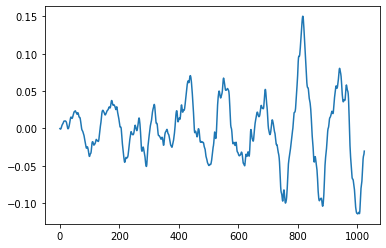

In [7]:
import pylab

sample = dataset.notes[54].samples[0]
window_size = 1024

pylab.plot(range(window_size), sample.get_onset_clip(window_size))

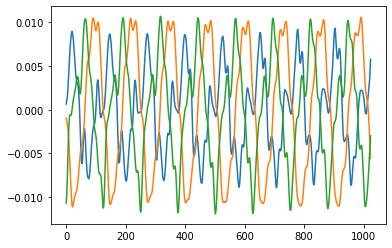

In [8]:
# 3 random clips
pylab.plot(range(window_size), sample.get_random_clip(window_size))
pylab.plot(range(window_size), sample.get_random_clip(window_size))
pylab.plot(range(window_size), sample.get_random_clip(window_size))
